^C


In [2]:
import gym
import pygame
import random
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
from tqdm import tqdm

In [3]:

class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, hidden_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, action_size)  

        self.init_weights()

    def init_weights(self):
        init.xavier_normal_(self.fc1.weight)
        init.xavier_normal_(self.fc2.weight)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [4]:
def mi_softmax(action_values, tau):
    preferences = action_values / tau
    max_preference = np.max(preferences, axis=0, keepdims=True)
    exp_preferences = np.exp(preferences - max_preference)
    sum_of_exp_preferences = np.sum(exp_preferences, axis=0, keepdims=True)
    action_probs = exp_preferences / sum_of_exp_preferences
    return action_probs

In [5]:
class QLearning:
    def __init__(self,data):
        state_size=data.get('state_dim')
        self.action_size=data.get('action_dim')
        hidden_size=data.get('hidden_dim')
        self.tau=data.get('tau')
        self.batch_size=data.get('batch_size')
        self.layer_size = np.array([state_size, self.action_size, hidden_size])
        self.q_network = QNetwork(state_size, self.action_size, hidden_size)
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=data.get('lr'))
        self.criteri = nn.MSELoss()
        self.gamma = data.get('gamma')
        self.last_action=None
        self.last_state=None
        self.action_probs=None
        self.memory=[]
    def agent_policy(self,q_values):
        q_values_array = q_values.detach().numpy()
        action_probs=mi_softmax(q_values_array ,self.tau)
        return action_probs
    def remember(self,last_state,action,reward,state,terminal):
        self.memory.append((last_state,action,reward,state,terminal))
    def replay (self):
        if len(self.memory) < self.batch_size:
            minibatch = random.sample(self.memory, len(self.memory))

        else:
            minibatch = random.sample(self.memory, self.batch_size)

        for last_state,action,reward,state,terminal in minibatch:
            self.optimizer.zero_grad()
            q_values_last=self.q_network(torch.tensor(last_state, dtype=torch.float32))
            if not terminal:
                q_values_new = self.q_network(torch.tensor(state, dtype=torch.float32))
                max_q_value = torch.max(q_values_new).item()        
                target=reward+self.gamma*max_q_value
            else:
                target=reward

            target_tensor = torch.tensor(target, dtype=torch.float32)
            loss = self.criteri (q_values_last[action], target_tensor )
            loss.backward()
            self.optimizer.step()

    def start(self,state):
        q_values = self.q_network(torch.tensor(state, dtype=torch.float32))
        action_probs=self.agent_policy(q_values)
        self.last_action= np.random.choice(len(action_probs), p=action_probs)
        self.last_state=state
        self.action_probs=action_probs
        return self.last_action
    
    def step(self,state,reward):
        q_values_new = self.q_network(torch.tensor(state, dtype=torch.float32))

        self.remember(self.last_state,self.last_action,reward,state,False)
        self.replay()

        action_probs=self.agent_policy(q_values_new)
        self.last_action=  np.random.choice(len(action_probs), p=action_probs)
        self.last_state=state
        self.action_probs=action_probs
        return self.last_action
    def end(self,reward):
        self.remember(self.last_state, self.last_action, reward, None, True)
        self.replay()

In [ ]:
print("xd")

xd


lr=0.0001, tau=0.001, hidden=64, batch_size=64:   0%|          | 0/100 [00:00<?, ?it/s]

lr=0.1, tau=1, hidden=200, batch_size=64: 100%|██████████| 100/100 [1:09:58<00:00, 41.98s/it]


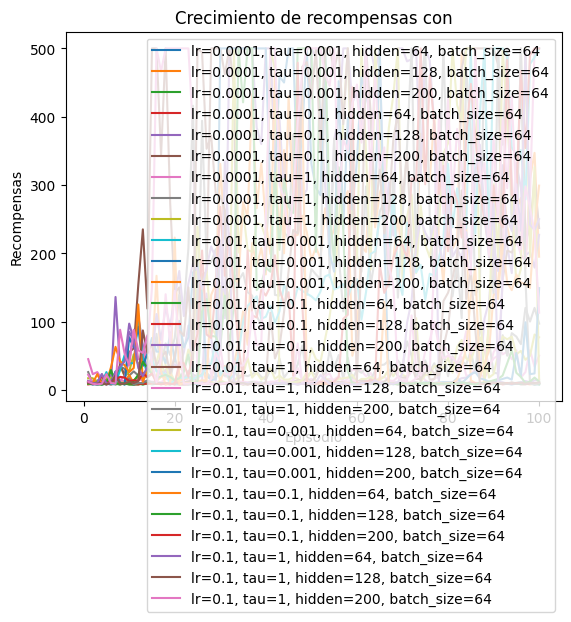

In [7]:

env = gym.make('CartPole-v1')
env.action_space.seed(42)

tau_s=[0.001,0.1,1]
hidden_dim=[64,128,200]
batch_sizes=[64]
lr_s=[0.0001,0.01,0.1]
resultados = {}
for lr in lr_s :
    for tau in tau_s:
        for hidden in hidden_dim:
            for batch_size in batch_sizes:
                data = {
                    'state_dim':4,# Puedes asignar un valor inicial si lo deseas
                    'action_dim':2,
                    'gamma':0.995,
                    'hidden_dim':hidden,
                    'lr':lr,
                    'tau':tau,
                    'batch_size':batch_size
                    }
                total_rewards_for_runs = []  
                agent=QLearning(data)
                for e in tqdm(range(100), desc=f"lr={lr}, tau={tau}, hidden={hidden}, batch_size={batch_size}"):
                    total_reward=0
                    observation, info = env.reset()
                    action=agent.start(observation)
                    for _ in range(3000):
                        observation, reward, terminated, truncated, info = env.step(action)
                        total_reward+=reward
                        if terminated or truncated:
                            agent.end(reward)
                            break
                        else:
                            action=agent.step(observation,reward)

                    total_rewards_for_runs.append(total_reward)
                resultados[f"lr={lr}, tau={tau}, hidden={hidden}, batch_size={batch_size}"] = total_rewards_for_runs

total_rewards_for_runs = np.array(total_rewards_for_runs)

for nombre, rendimientos in resultados.items():
    plt.plot(range(1, len(rendimientos) + 1), rendimientos, label=nombre)
plt.xlabel('Episodio')
plt.ylabel('Recompensas')
plt.title('Crecimiento de recompensas con')
plt.legend()
plt.show()
env.close()


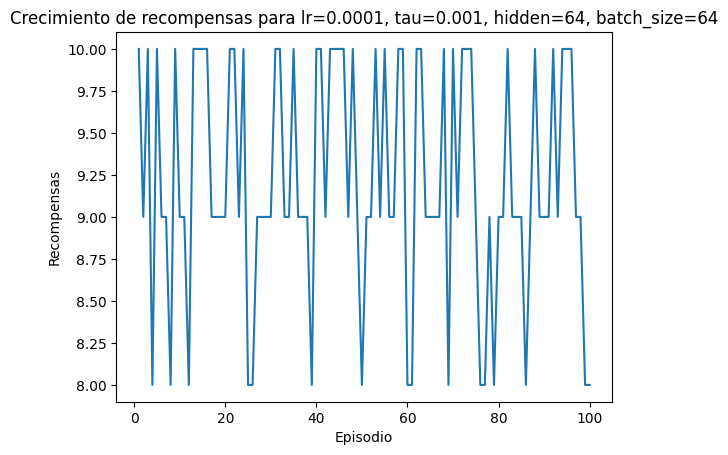

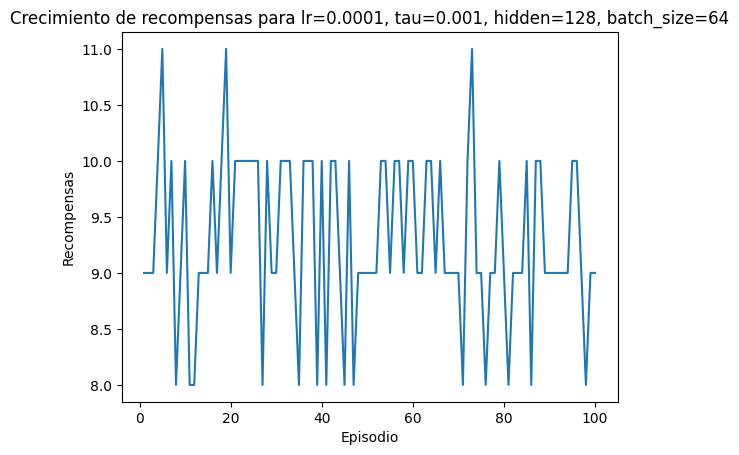

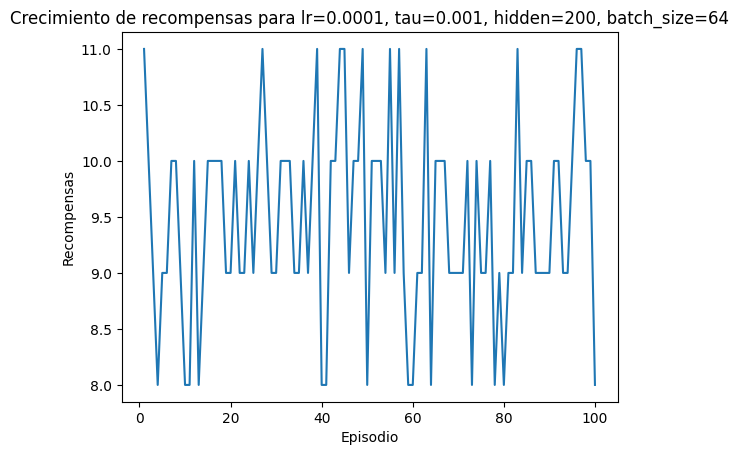

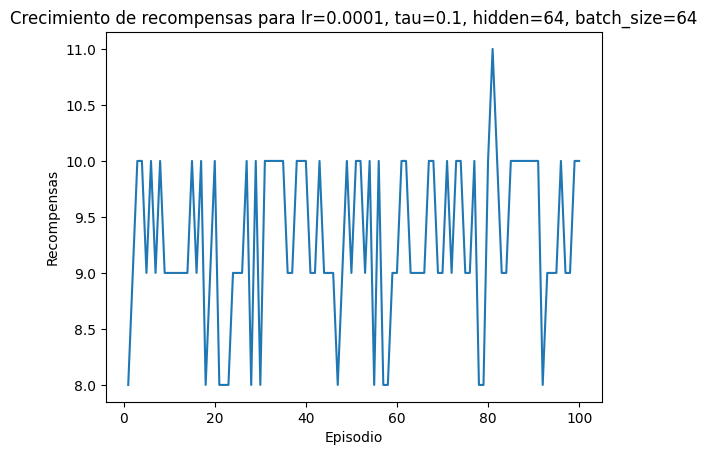

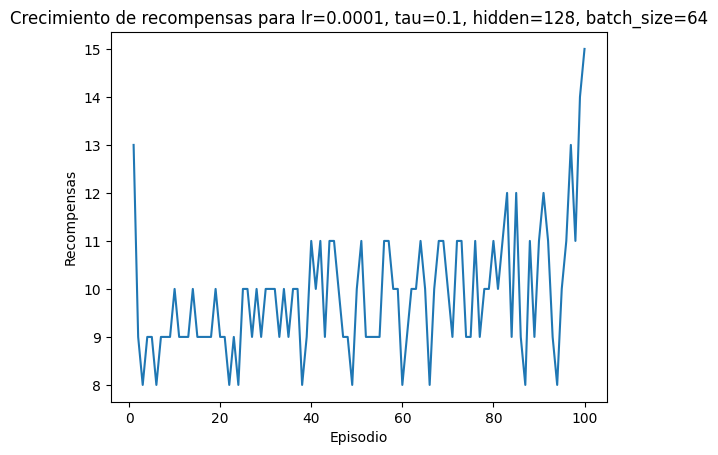

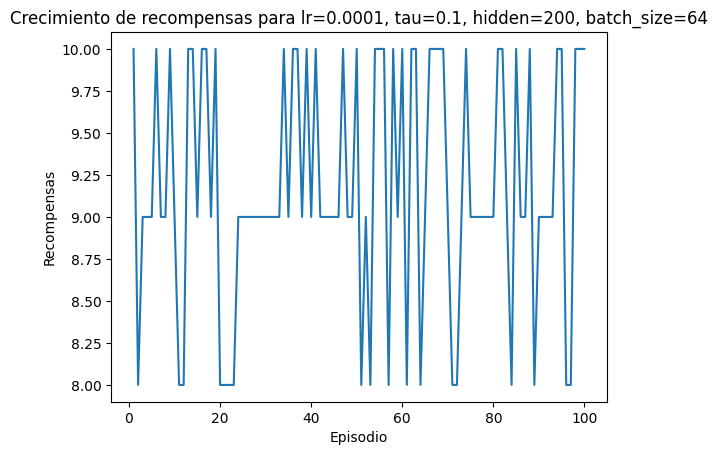

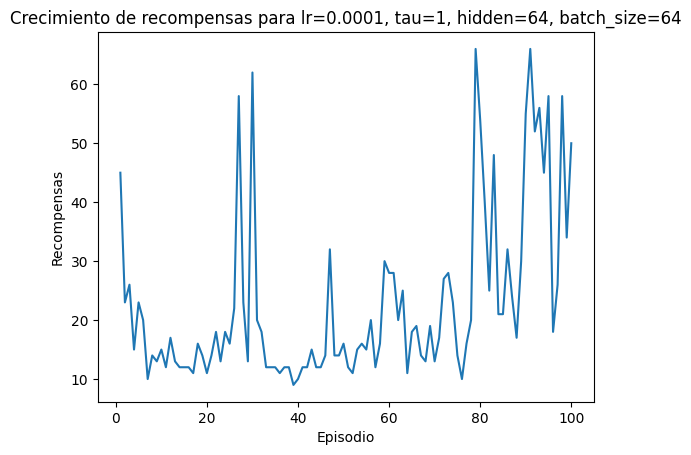

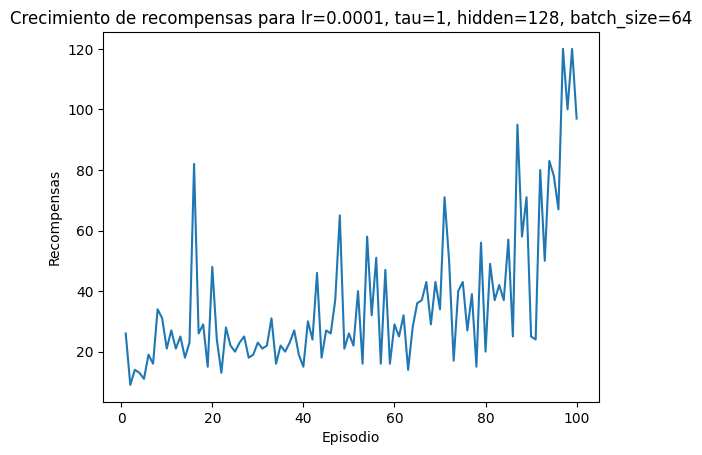

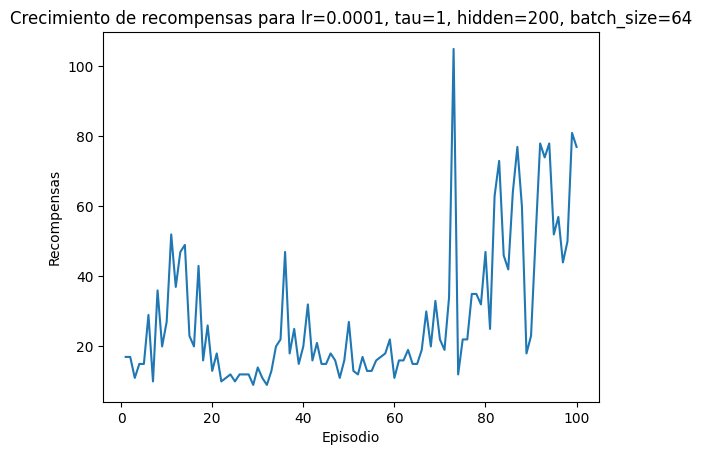

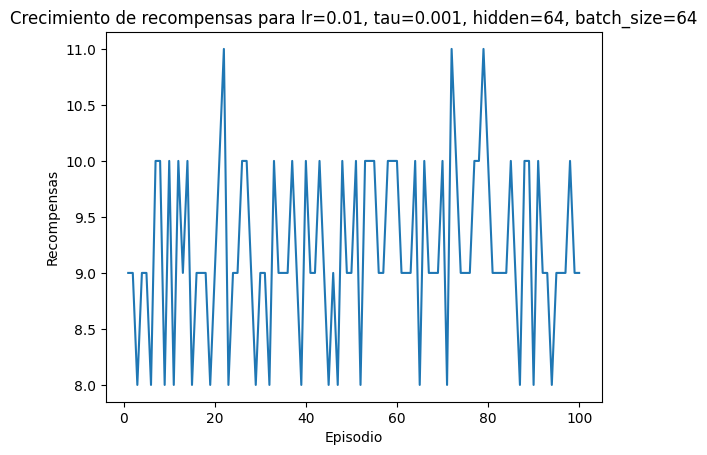

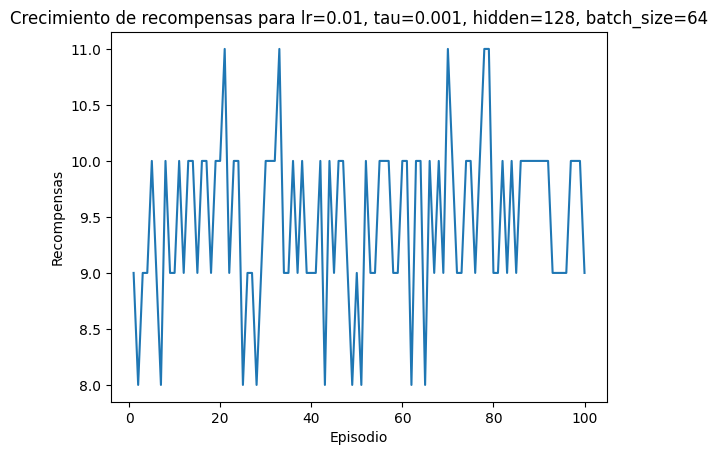

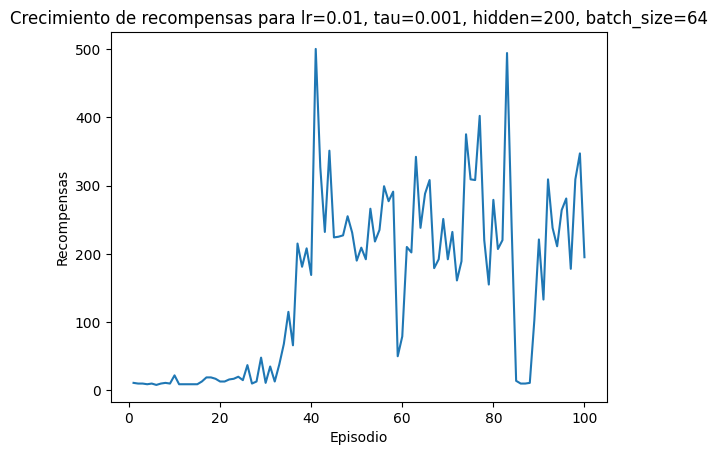

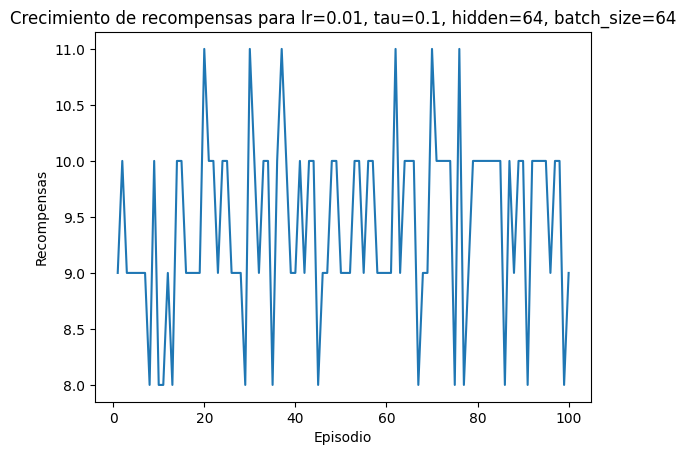

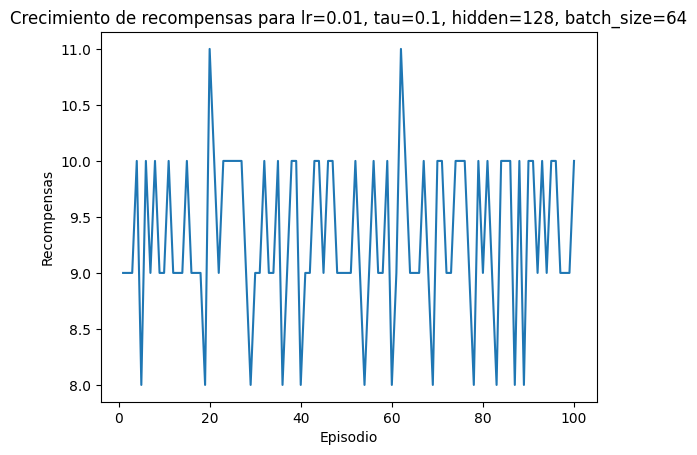

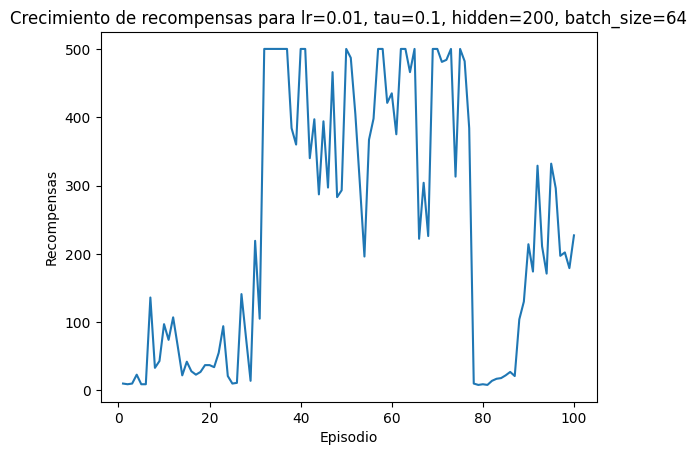

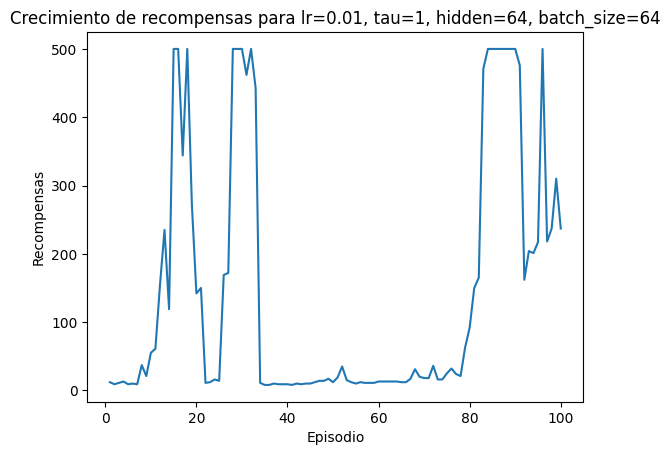

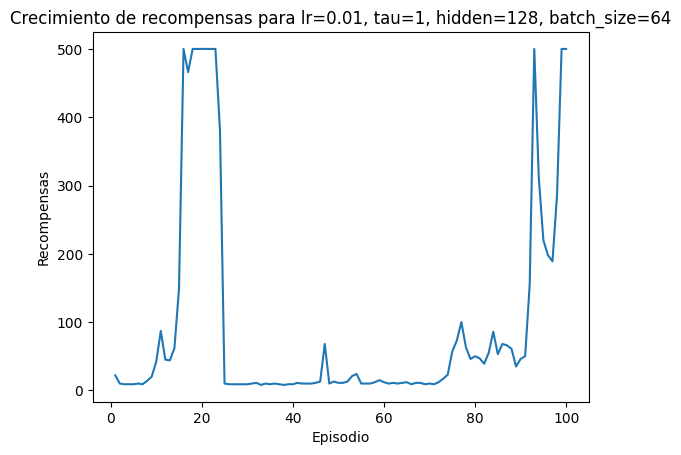

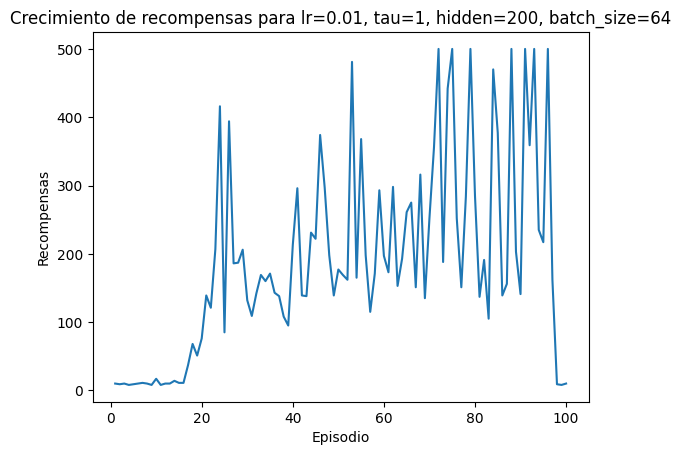

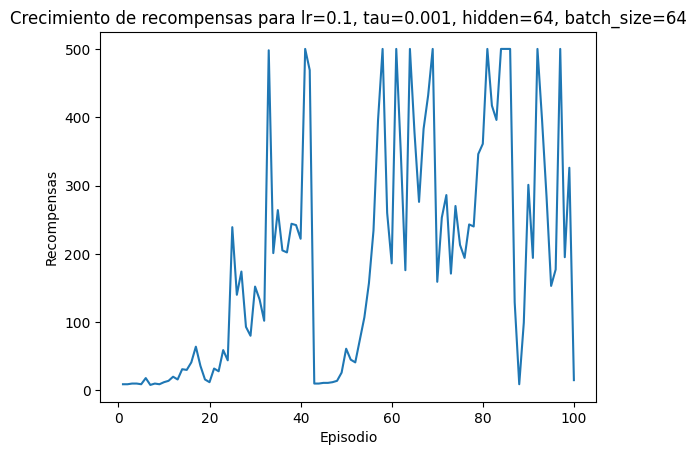

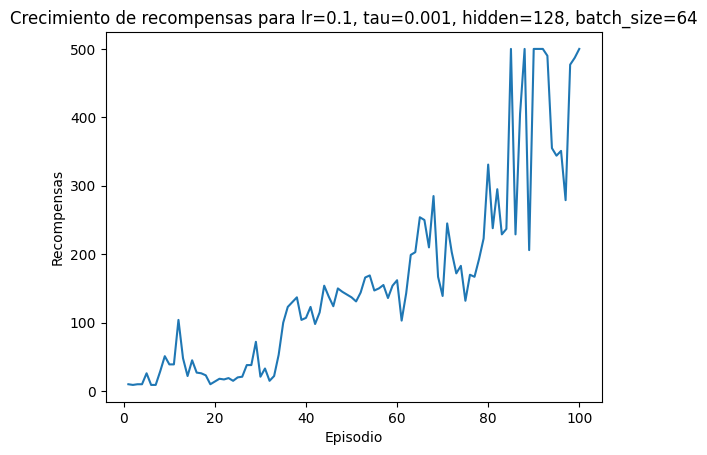

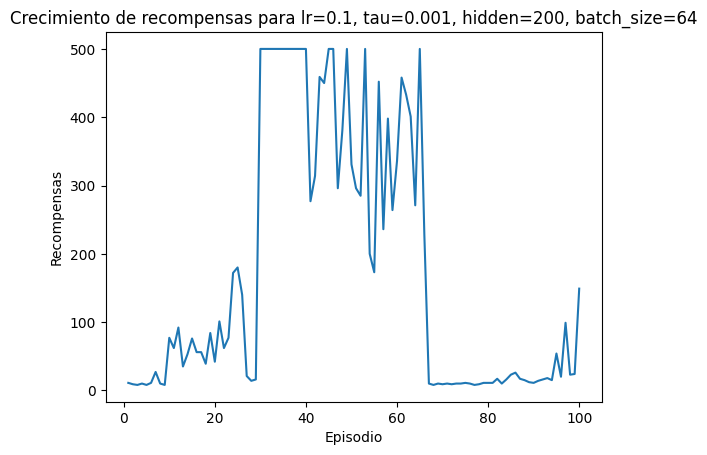

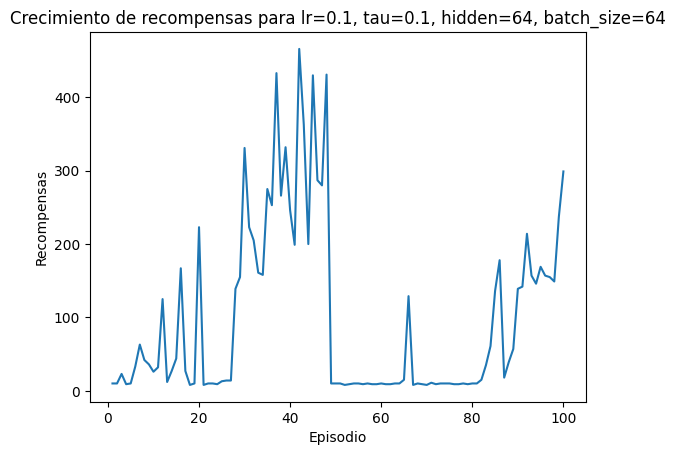

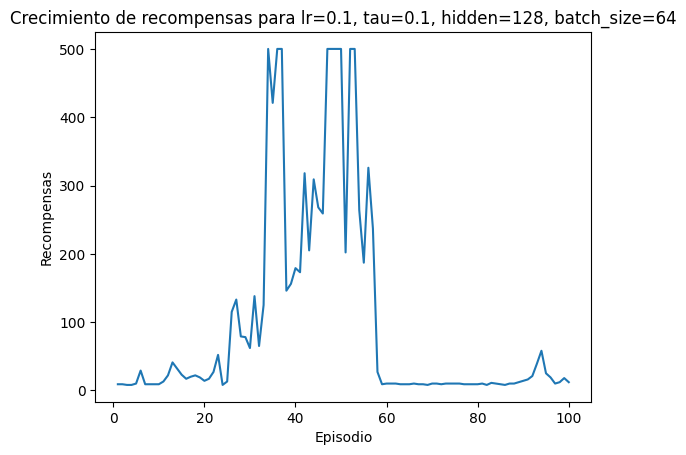

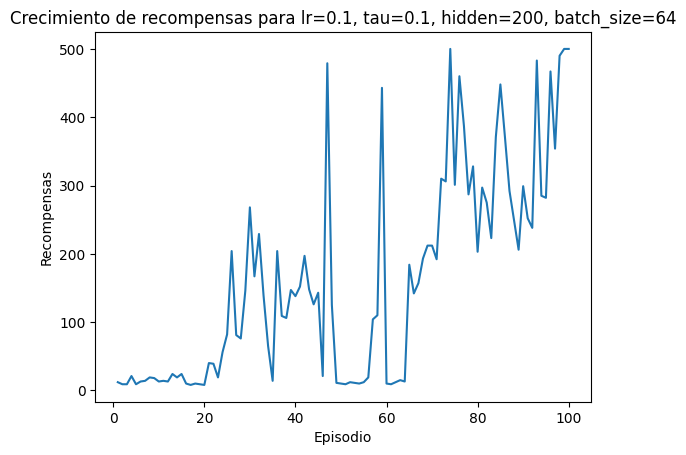

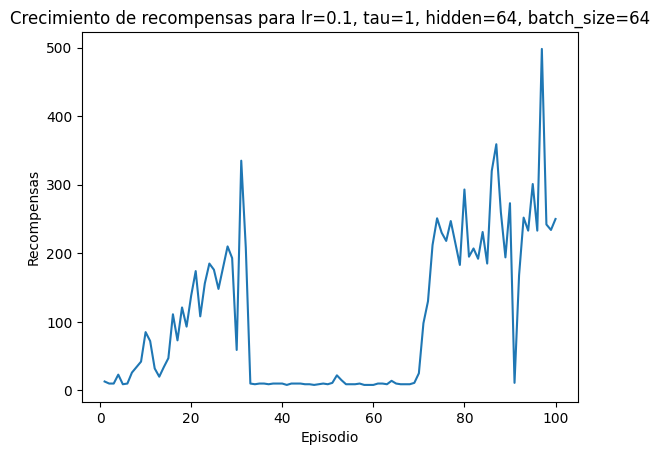

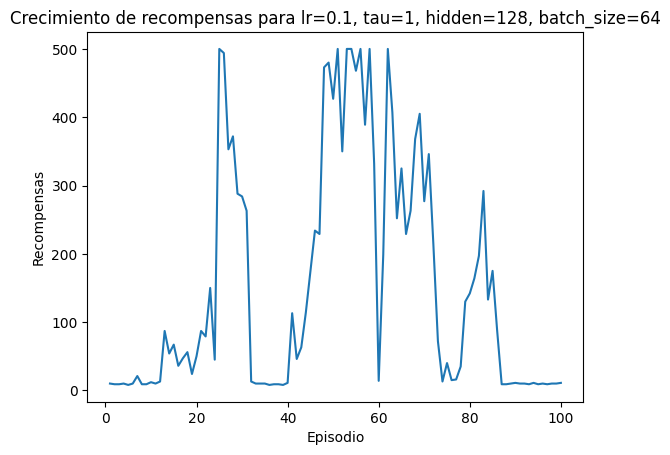

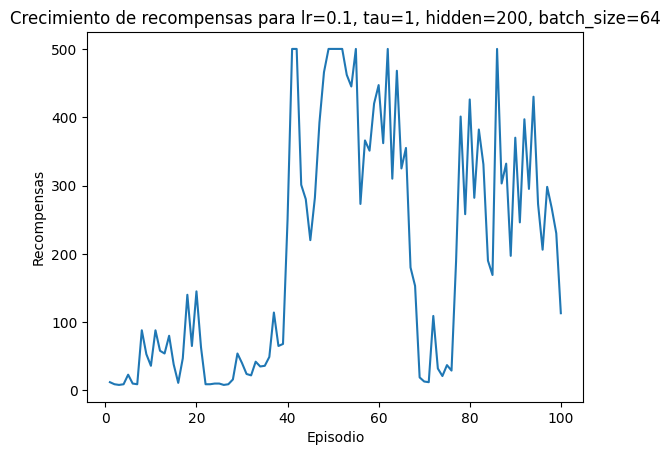

In [9]:
for i, (nombre, rendimientos) in enumerate(resultados.items()):
    plt.figure(i)
    plt.plot(range(1, len(rendimientos) + 1), rendimientos)
    plt.xlabel('Episodio')
    plt.ylabel('Recompensas')
    plt.title(f'Crecimiento de recompensas para {nombre}')
    plt.show()


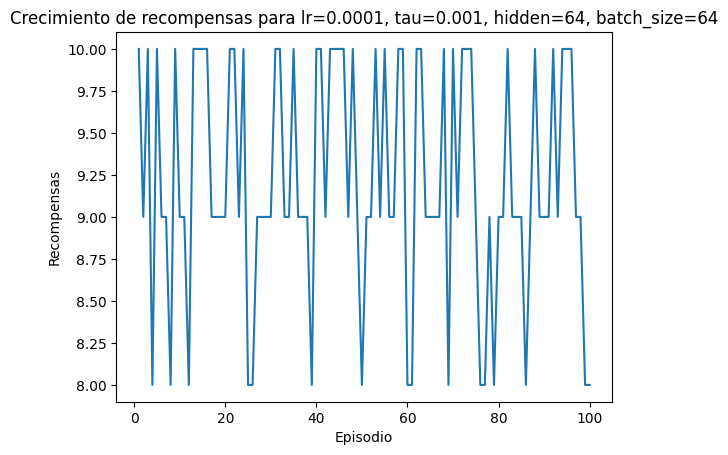

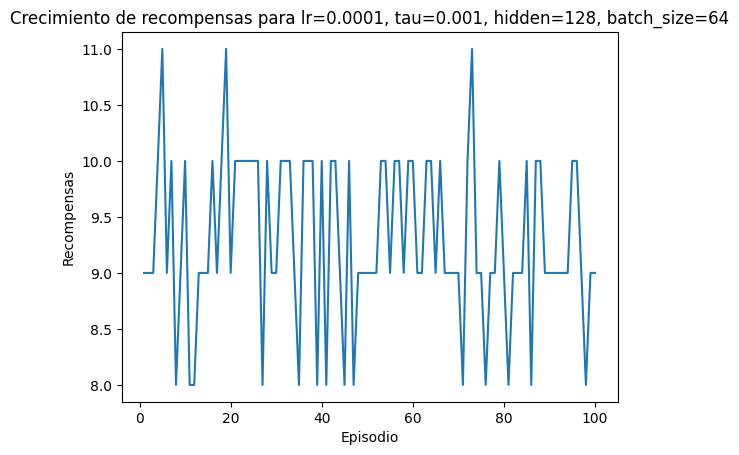

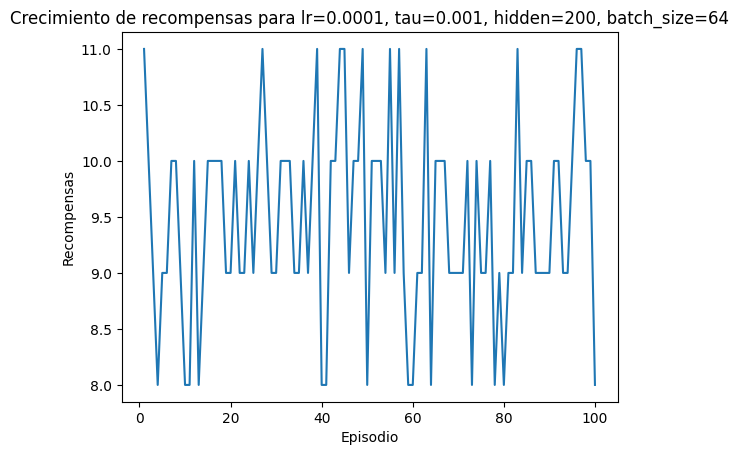

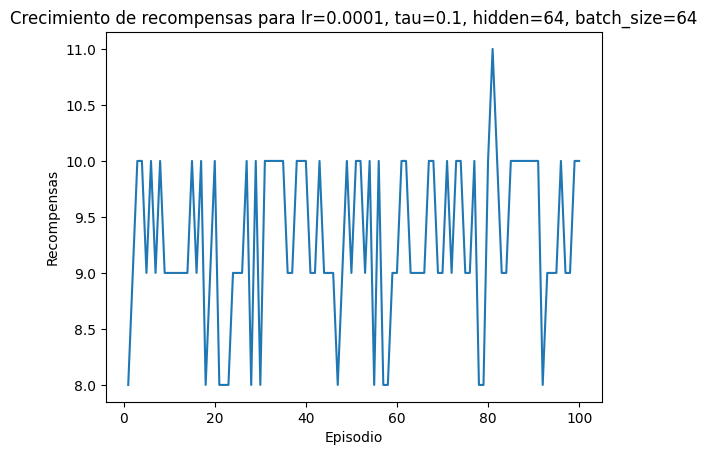

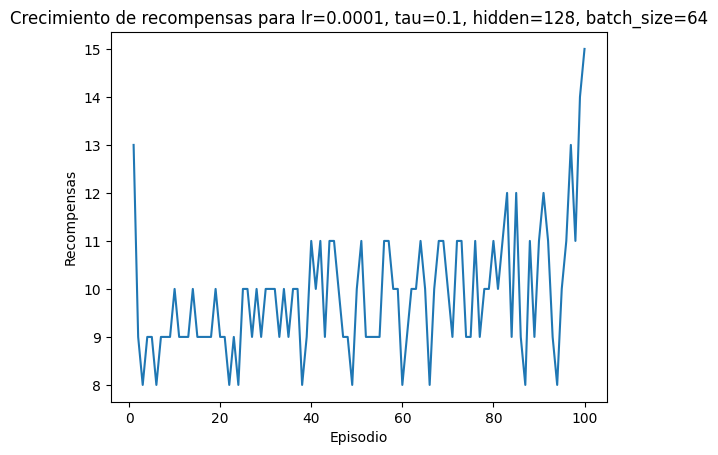

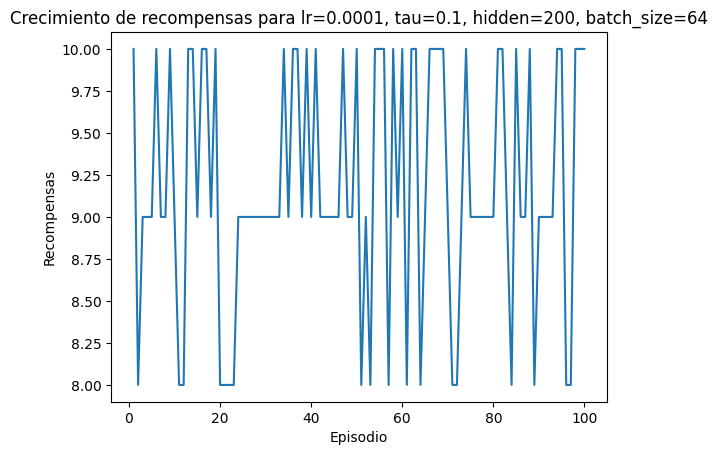

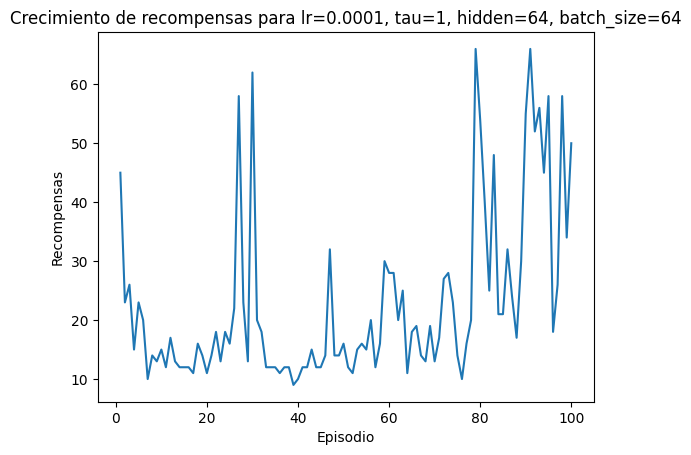

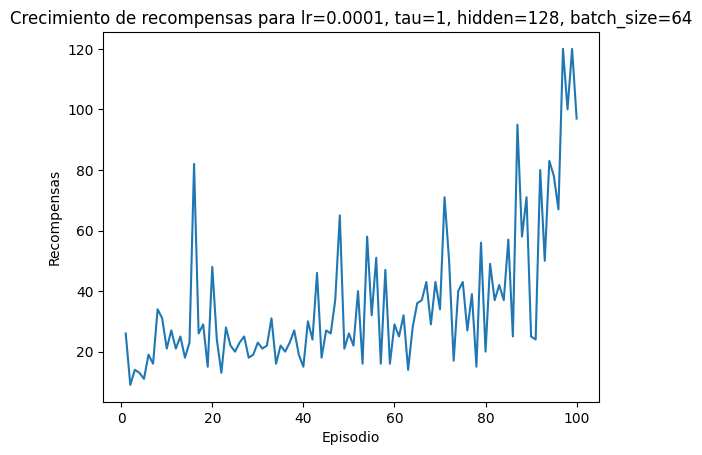

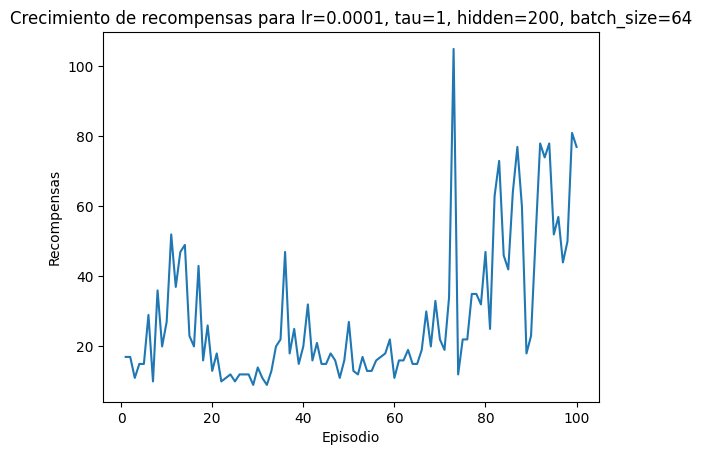

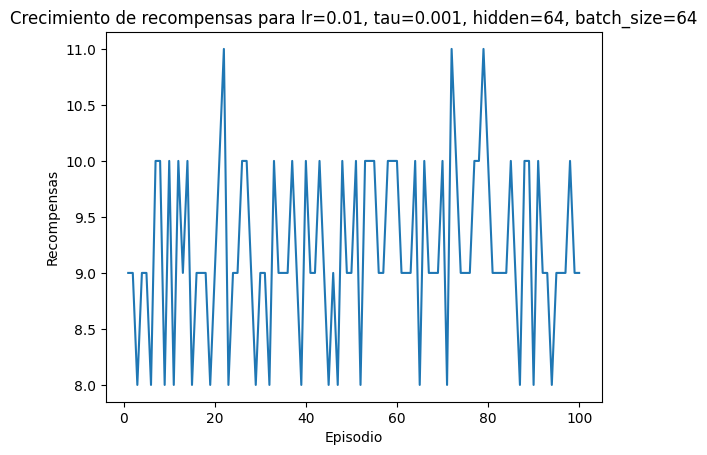

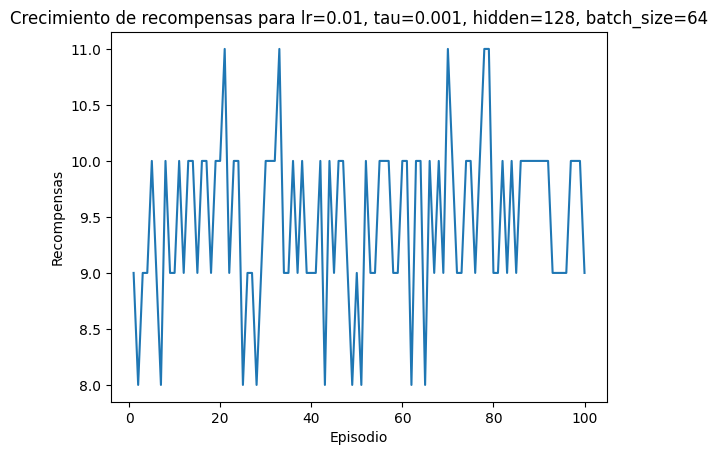

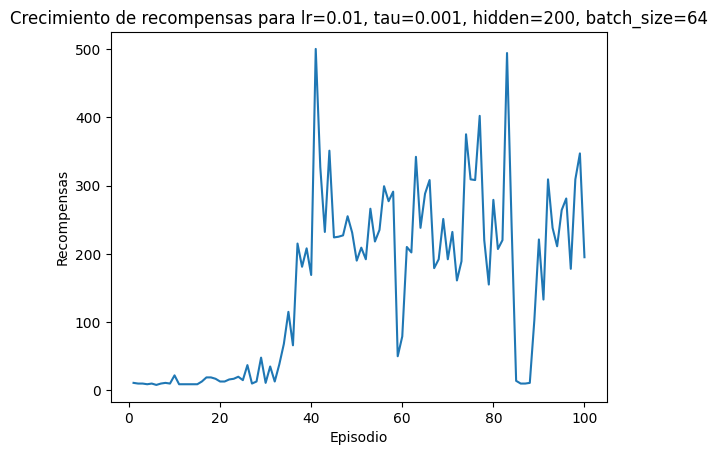

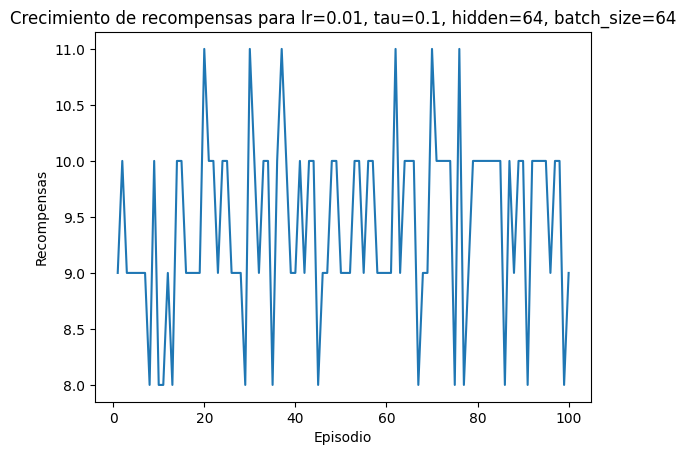

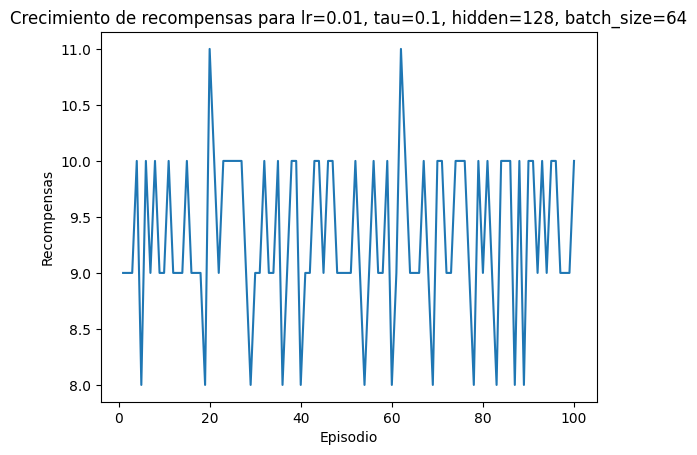

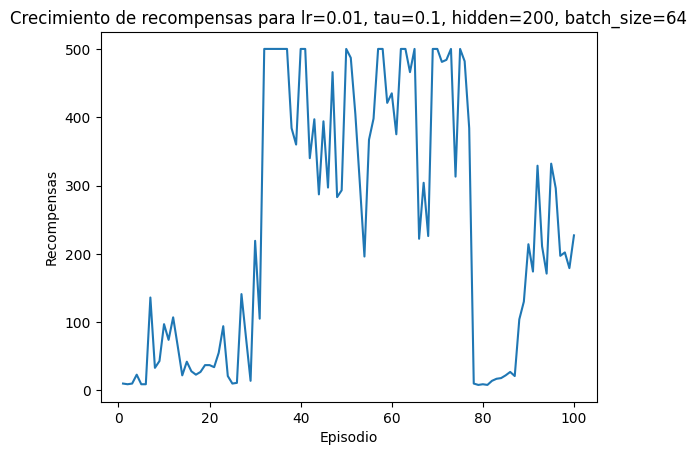

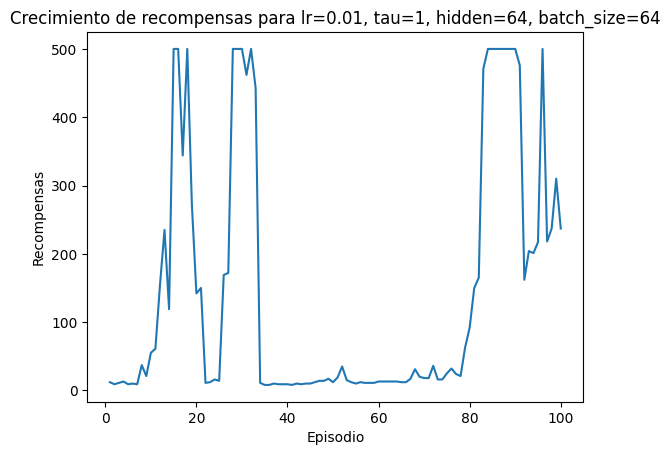

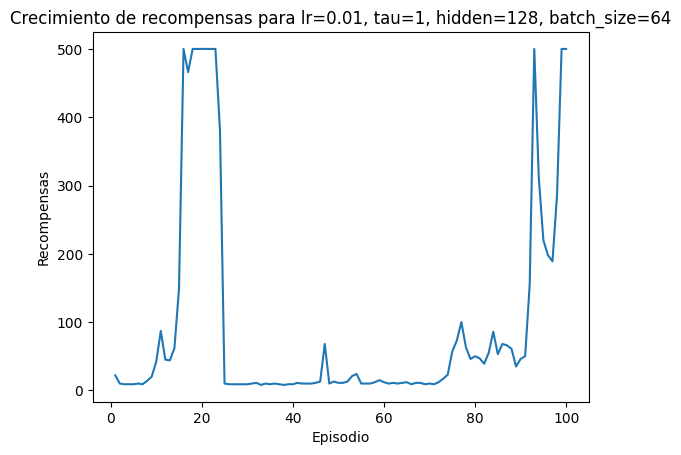

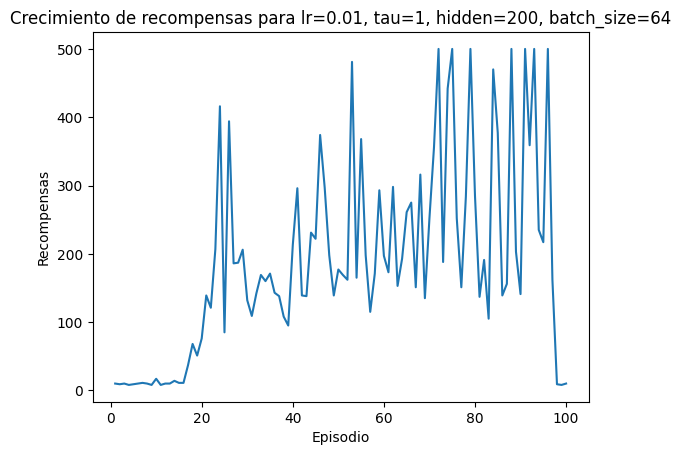

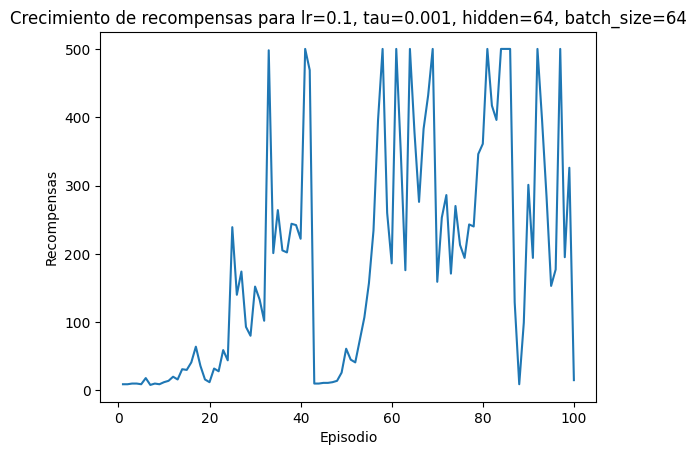

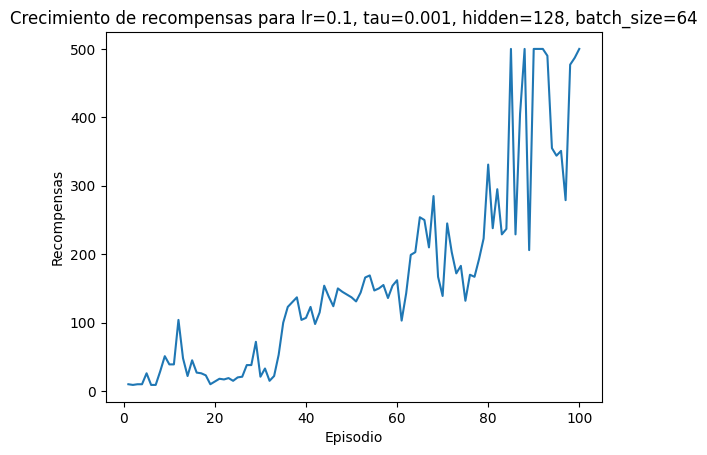

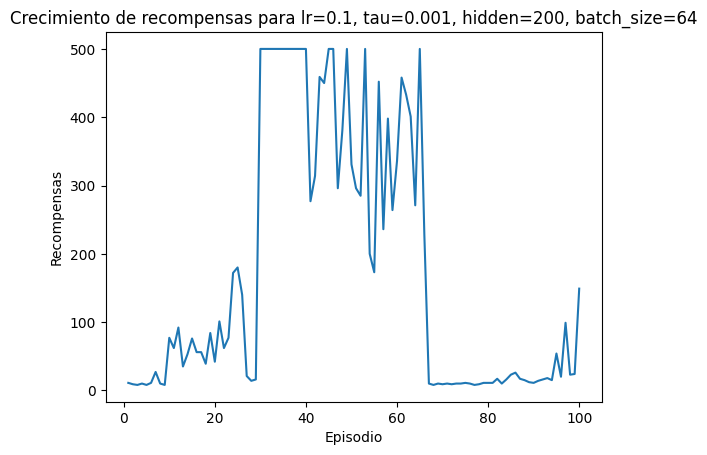

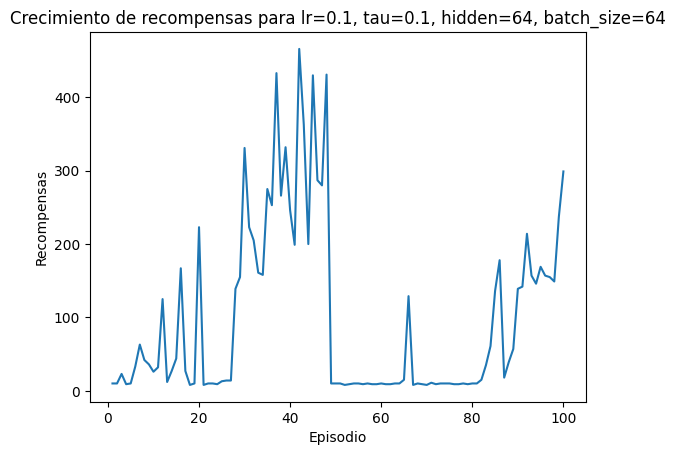

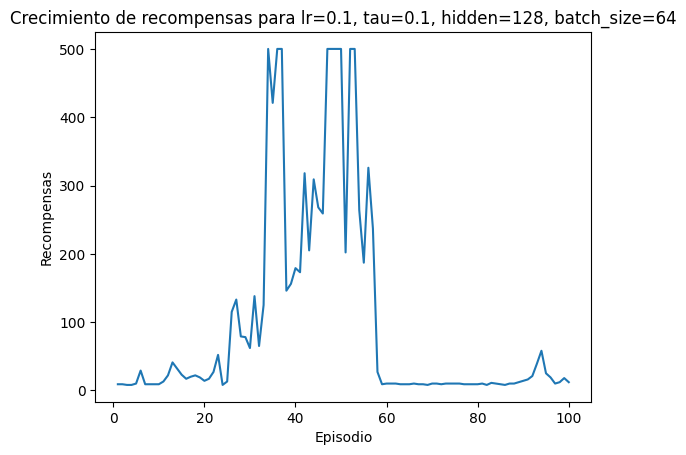

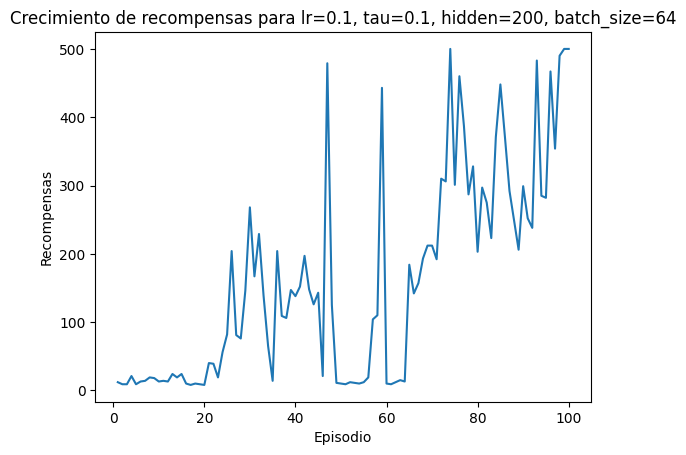

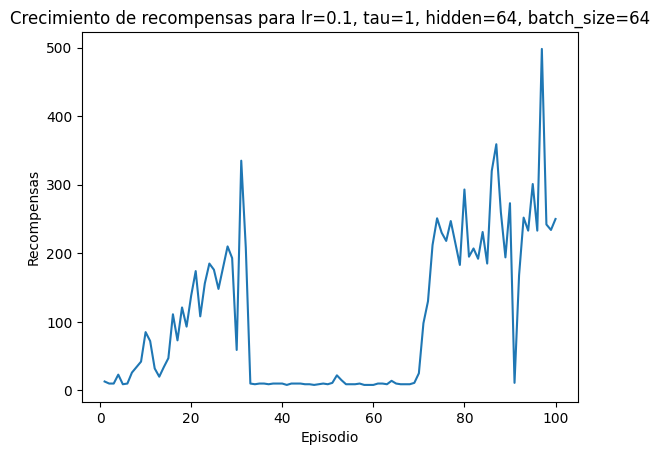

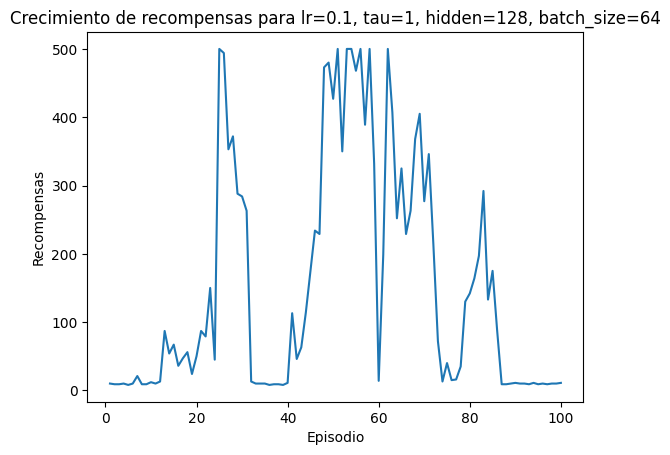

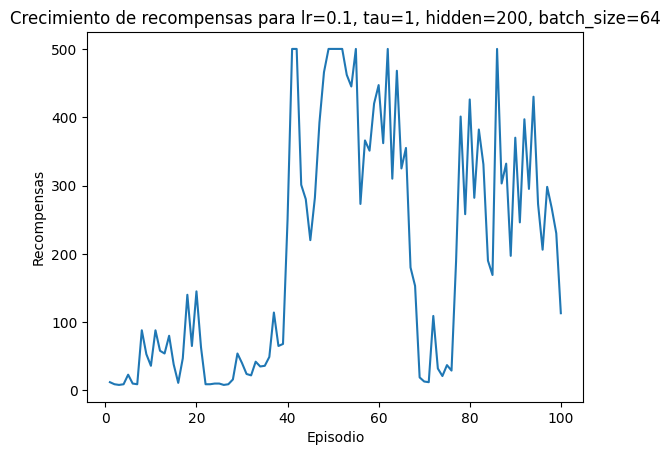

In [11]:
resultados_importantes=resultados
for i, (nombre, rendimientos) in enumerate(resultados_importantes.items()):
    plt.figure(i)
    plt.plot(range(1, len(rendimientos) + 1), rendimientos)
    plt.xlabel('Episodio')
    plt.ylabel('Recompensas')
    plt.title(f'Crecimiento de recompensas para {nombre}')
    plt.show()


In [13]:
print(resultados)

{'lr=0.0001, tau=0.001, hidden=64, batch_size=64': [10.0, 9.0, 10.0, 8.0, 10.0, 9.0, 9.0, 8.0, 10.0, 9.0, 9.0, 8.0, 10.0, 10.0, 10.0, 10.0, 9.0, 9.0, 9.0, 9.0, 10.0, 10.0, 9.0, 10.0, 8.0, 8.0, 9.0, 9.0, 9.0, 9.0, 10.0, 10.0, 9.0, 9.0, 10.0, 9.0, 9.0, 9.0, 8.0, 10.0, 10.0, 9.0, 10.0, 10.0, 10.0, 10.0, 9.0, 10.0, 9.0, 8.0, 9.0, 9.0, 10.0, 9.0, 10.0, 9.0, 9.0, 10.0, 10.0, 8.0, 8.0, 10.0, 10.0, 9.0, 9.0, 9.0, 9.0, 10.0, 8.0, 10.0, 9.0, 10.0, 10.0, 10.0, 9.0, 8.0, 8.0, 9.0, 8.0, 9.0, 9.0, 10.0, 9.0, 9.0, 9.0, 8.0, 9.0, 10.0, 9.0, 9.0, 9.0, 10.0, 9.0, 10.0, 10.0, 10.0, 9.0, 9.0, 8.0, 8.0], 'lr=0.0001, tau=0.001, hidden=128, batch_size=64': [9.0, 9.0, 9.0, 10.0, 11.0, 9.0, 10.0, 8.0, 9.0, 10.0, 8.0, 8.0, 9.0, 9.0, 9.0, 10.0, 9.0, 10.0, 11.0, 9.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 8.0, 10.0, 9.0, 9.0, 10.0, 10.0, 10.0, 9.0, 8.0, 10.0, 10.0, 10.0, 8.0, 10.0, 8.0, 10.0, 10.0, 9.0, 8.0, 10.0, 8.0, 9.0, 9.0, 9.0, 9.0, 9.0, 10.0, 10.0, 9.0, 10.0, 10.0, 9.0, 10.0, 10.0, 9.0, 9.0, 10.0, 10.0, 9.0, 

In [15]:
tau_s=[0.001,0.1,1]
hidden_dim=[64,128,200]
batch_sizes=[64]
lrp=0.001
for tau in tau_s:
    for hidden in hidden_dim:
        for batch_size in batch_sizes:
            data = {
                    'state_dim':4,# Puedes asignar un valor inicial si lo deseas
                    'action_dim':2,
                    'gamma':0.995,
                    'hidden_dim':hidden,
                    'lr':lrp,
                    'tau':tau,
                    'batch_size':batch_size
                }
            total_rewards_for_runs = []  
            agent=QLearning(data)
            for e in tqdm(range(100), desc=f"lr={lrp}, tau={tau}, hidden={hidden}, batch_size={batch_size}"):
                total_reward=0
                observation, info = env.reset()
                action=agent.start(observation)
                for _ in range(3000):
                    observation, reward, terminated, truncated, info = env.step(action)
                    total_reward+=reward
                    if terminated or truncated:
                        agent.end(reward)
                        break
                    else:
                        action=agent.step(observation,reward)

                total_rewards_for_runs.append(total_reward)
            resultados[f"lr={lrp}, tau={tau}, hidden={hidden}, batch_size={batch_size}"] = total_rewards_for_runs
total_rewards_for_runs = np.array(total_rewards_for_runs)

for nombre, rendimientos in resultados.items():
    plt.plot(range(1, len(rendimientos) + 1), rendimientos, label=nombre)
plt.xlabel('Episodio')
plt.ylabel('Recompensas')
plt.title('Crecimiento de recompensas con')
plt.legend()
plt.show()
env.close()

lr=0.001, tau=0.001, hidden=128, batch_size=64:  71%|███████   | 71/100 [24:28<09:59, 20.68s/it]


KeyboardInterrupt: 